In [1]:
%load_ext autoreload
%autoreload 2

In [161]:
import os
path_hdr_vdp3 = "/data2/saikiran.tedla/hdrvideo/diff/metrics/jpeg-ai-qaf-feature-HDR-VDP2.2-main"
#add to system path
import sys
sys.path.append(path_hdr_vdp3)

import matlab.engine

# Start MATLAB engine
eng = matlab.engine.start_matlab()
eng.addpath(r'/home/tedlasai/lens_shading/hdrvdp', nargout=0)



ModuleNotFoundError: No module named 'matlab'

Max of cv2_hdr_gt before processing: 1.0
clip negative values
Max pred before color transform: 1.0
Max gt before color transform: 1000.0
Max pred after color transform and CRF: 916.038137682
Max gt after color transform: 1574.75959376
IN HERE [[  1.11061635e+00   3.04895243e-03   1.03842613e-03]
 [ -6.64494388e-03   9.77233371e-01  -2.13034446e-03]
 [  3.31999694e-03   1.44033655e-02   9.90324729e-01]]


{'P_map': array([[ 0.55718319,  0.58359712,  0.60777199, ...,  0.11339933,
         0.10031018,  0.08829562],
       [ 0.56822593,  0.5947661 ,  0.61901247, ...,  0.11788096,
         0.10443291,  0.09206532],
       [ 0.57598187,  0.60259919,  0.62688462, ...,  0.12151433,
         0.10781771,  0.09519743],
       ..., 
       [ 0.41397447,  0.44331521,  0.47199088, ...,  0.48062626,
         0.46108623,  0.43980395],
       [ 0.38205595,  0.4097891 ,  0.43701436, ...,  0.45406069,
         0.43529018,  0.41486945],
       [ 0.35039646,  0.3763569 ,  0.40194037, ...,  0.42607935,
         0.40817506,  0.38871827]]), 'Q': 7.5293205001916412, 'Q_JOD': 8.3431632067049843}


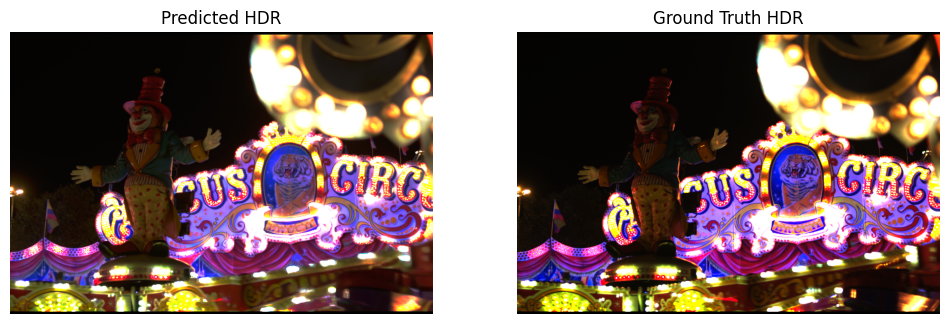

Mean Pred after color transform: 60.9306067645
Max Pred: 1086.32571391
Max GT: 1574.75959376
Max PU21 Pred: 413.412092327
Max PU21 GT: 455.073510281


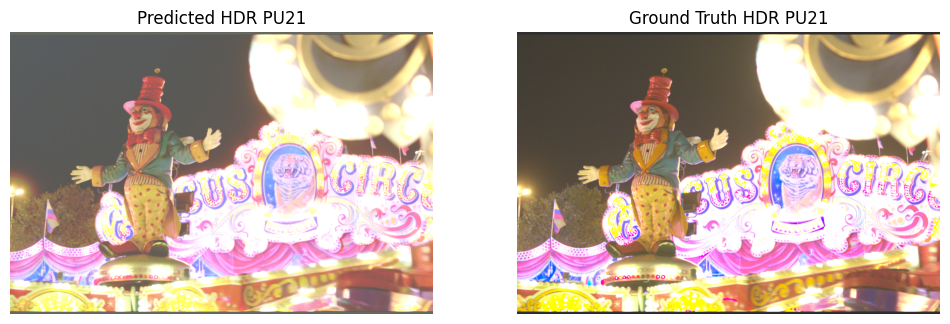

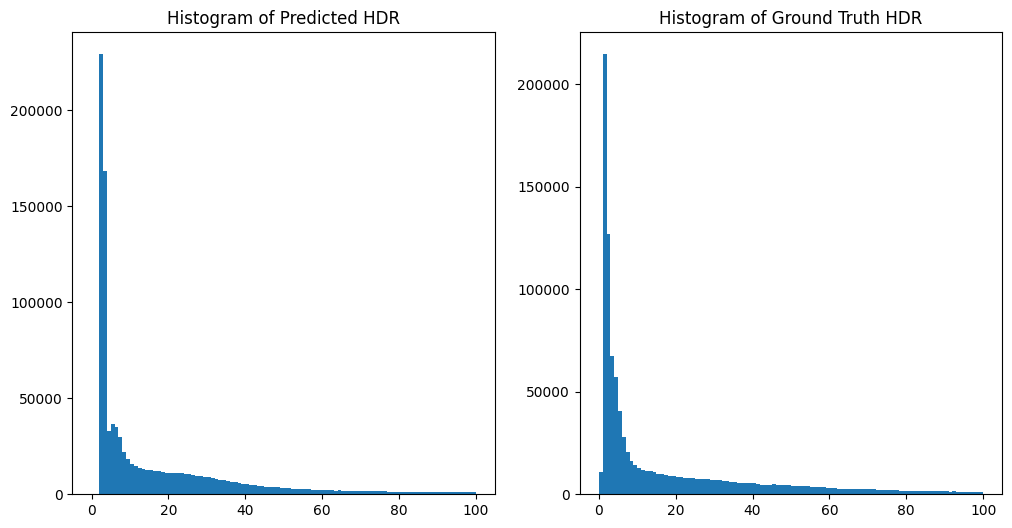

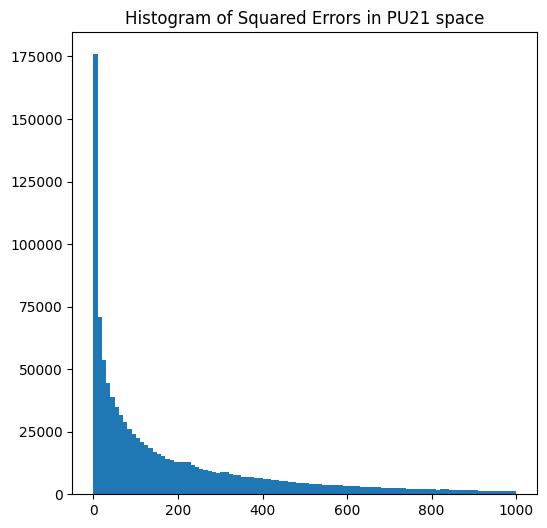

MSE in PU21 space: 657.108867896
Median MSE in PU21 space: 128.788188007
PSNR in PU21 space: 19.9884260245
lambda_: 0.02
VSI score: 0.9587964256810794


In [ ]:
pred_path = "/data2/saikiran.tedla/hdrvideo/diff/models/train/three_exposures/val_videos/hdr_pred/ours_epoch-101_item-6/frame_0001.hdr"
gt_path =  "/data2/saikiran.tedla/hdrvideo/diff/models/train/three_exposures/val_videos/hdr_gt/gt_epoch-101_item-6/frame_0001.hdr"
#pred_path = "/data2/saikiran.tedla/hdrvideo/diff/models/train/finetune_decoder_stage2decoder_multiexposureloss/val_videos/hdr_pred/ours_epoch-399_item-6/frame_0001.hdr"
#gt_path = "/data2/saikiran.tedla/hdrvideo/diff/models/train/finetune_decoder_stage2decoder_multiexposureloss/val_videos/hdr_gt/gt_epoch-399_item-6/frame_0001.hdr"

#EXR Test
# pred_path = "/data2/saikiran.tedla/hdrvideo/diff/data/stuttgart/carousel_fireworks_02/carousel_fireworks_02_000936.exr"
# gt_path = "/data2/saikiran.tedla/hdrvideo/diff/data/stuttgart/carousel_fireworks_02/carousel_fireworks_02_000936.exr"

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

def pre_hdr_p3(img):
    eps = 1e-8
    flat = img.reshape(-1)

    # 0.1 and 99.9 percentiles
    p_low = np.percentile(flat, 0.1)
    p_high = np.percentile(flat, 99.9)

    c = 1.0
    d = 1000.0

    # linear mapping
    out = (img - p_low) * (d - c) / (p_high - p_low + eps) + c

    # clamp negative values
    out = np.maximum(out, 0)

    return out

def polyfit_ridge(x, y, deg, lam=1e-3, w0=None):
    # Build Vandermonde matrix
    V = np.vander(x, deg+1)

    # Prior center
    if w0 is None:
        w0 = np.zeros(deg+1)

    # Solve (V^T V + lam I) w = V^T y + lam w0
    A = V.T @ V + lam * np.eye(deg+1)
    b = V.T @ y + lam * w0
    w = np.linalg.solve(A, b)

    return w

import numpy as np
import cv2

def downsample_inter_area(img, factor):
    """
    Downsample using cv2.INTER_AREA (proper averaging).
    """
    if factor <= 1:
        return img
    H, W = img.shape[:2]
    return cv2.resize(
        img,
        (W // factor, H // factor),
        interpolation=cv2.INTER_AREA,
    )

def fit_and_apply_crf(
    pred,
    gt,
    deg=3,
    down_factor=4,
    p_low=10,
    p_high=90,
):
    """
    Fit a per-channel polynomial CRF in log space (pred → gt) using
    only values where gt lies between chosen percentiles.
    Applies the CRF to the full-resolution pred.
    """
    eps = 1e-3
    H, W, C = pred.shape
    assert C == 3

    # --- Downsample for fitting using INTER_AREA ---
    pred_fit = downsample_inter_area(pred, down_factor)
    gt_fit   = downsample_inter_area(gt,   down_factor)

    # --- Flatten ---
    pred_f = pred_fit.reshape(-1, 3)
    gt_f   = gt_fit.reshape(-1, 3)
    num_pixels = pred_f.shape[0] * pred_f.shape[1]

    # --- Compute percentiles per channel on gt ---
    p_lo_vals = np.percentile(gt_f, p_low,  axis=0)
    p_hi_vals = np.percentile(gt_f, p_high, axis=0)

    # --- Valid mask: positive + percentile range ---
    valid_positive = (pred_f > 0).all(axis=1) & (gt_f > 0).all(axis=1)
    valid_range = np.ones(len(gt_f), dtype=bool)
    for c in range(3):
        valid_range &= (gt_f[:, c] >= p_lo_vals[c]) & (gt_f[:, c] <= p_hi_vals[c])

    valid = valid_positive & valid_range

    pred_f = pred_f[valid]
    gt_f   = gt_f[valid]

    # --- Log regression ---
    log_pred = np.log(pred_f + eps)
    log_gt   = np.log(gt_f   + eps)

    coeffs = np.zeros((3, deg + 1), dtype=np.float32)
    for c in range(3):
        x = log_pred[:, c]
        y = log_gt[:, c]
        coeffs[c] = polyfit_ridge(
            x, y, deg,
            lam=0.1 * num_pixels / (deg + 1)
        )

    # --- Apply CRF to full-res pred ---
    pred_safe = np.clip(pred, eps, None)
    log_pred_full = np.log(pred_safe)

    corrected = np.zeros_like(pred_safe)
    for c in range(3):
        p = coeffs[c]
        log_corr = np.polyval(p, log_pred_full[..., c])
        corrected[..., c] = np.exp(log_corr)

    return corrected, coeffs



cv2_hdr_pred = cv2.imread(pred_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)[:, :, ::-1].copy()
cv2_hdr_gt = cv2.imread(gt_path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)[:, :, ::-1].copy()

print("Max of cv2_hdr_gt before processing:", np.max(cv2_hdr_gt))
#add noise to cv2_hdr_pred for testing
noise = np.random.normal(0, 0.05, cv2_hdr_pred.shape)
#cv2_hdr_pred += noise
print("clip negative values")

cv2_hdr_pred = np.clip(cv2_hdr_pred, 0, None)

cv2_hdr_gt = pre_hdr_p3(cv2_hdr_gt)

print("Max pred before color transform:", np.max(cv2_hdr_pred))
print("Max gt before color transform:", np.max(cv2_hdr_gt))

#ALEX To SRGB #1.617523 -0.537287 -0.080237
#-0.070573 1.334613 -0.26404
#-0.021102 -0.226954 1.248056
alexa_to_srgb  = np.array([[ 1.617523, -0.537287, -0.080237],
                              [-0.070573,  1.334613, -0.26404 ],
                              [-0.021102, -0.226954,  1.248056]])

#apply the color transform to both predicted and gt hdr images
cv2_hdr_pred = cv2_hdr_pred @ alexa_to_srgb.T
cv2_hdr_gt = cv2_hdr_gt @ alexa_to_srgb.T

#Dille, Careaga, Aksoy - ECCV 2024: We determine the best scale to align the input reconstruction with the ground truth with least-squares, using only values between the 10th and 90th percentiles to avoid outliers
gt_lum = np.sum(cv2_hdr_gt, axis=2)
p10, p90 = np.percentile(gt_lum, 10), np.percentile(gt_lum, 90)
mask = (gt_lum >= p10) & (gt_lum <= p90)

pred_masked = cv2_hdr_pred[mask]  # shape (N, C)
gt_masked   = cv2_hdr_gt[mask]    # shape (N, C)

# Flatten over channels so we solve one global (a, b) for all channels
x = pred_masked.reshape(-1)
y = gt_masked.reshape(-1)

# Build design matrix [x, 1]
A = np.stack([x, np.ones_like(x)], axis=1)   # shape (N*C, 2)

# Solve min ||A @ [a, b] - y||^2
(a, b), *_ = np.linalg.lstsq(A, y, rcond=None)

# Apply to full HDR prediction
cv2_hdr_pred = cv2_hdr_pred * a + b

# #print error of cv2_hdr_pred and cv2_hdr_gt after color transform and linear alignment
# mse = np.mean((cv2_hdr_pred - cv2_hdr_gt)**2)
# print("MSE after color transform and linear alignment:", mse)

# #implement CRF alignment

# #fit and apply crf
# from alignment import crf_correction_luv_bt709, ptf




# #print("CRF Coefficients per channel (R, G, B):", coeffs)
# #HDRVDP3
# from VDP3.hdrvdp3 import hdrvdp3
# print("cv2_hdr_gt shape:", cv2_hdr_gt.shape)
# cv2_hdr_pred_w_crf = np.clip(cv2_hdr_pred, 0, None)
# cv2_hdr_gt_w_crf = np.clip(cv2_hdr_gt, 0, None)

# median_gt = np.median(cv2_hdr_gt_w_crf)
# pq_hdr_pred_w_crf = ptf(cv2_hdr_pred_w_crf *500/ median_gt)
# pq_hdr_gt_w_crf = ptf(cv2_hdr_gt_w_crf *500/ median_gt)
# pq_hdr_pred_w_crf, w = crf_correction_luv_bt709(pq_hdr_pred_w_crf, pq_hdr_gt_w_crf)

# cv2_hdr_pred_w_crf = ptf(pq_hdr_pred_w_crf, forward=False) * median_gt /500
# cv2_hdr_gt_w_crf = ptf(pq_hdr_gt_w_crf, forward=False) * median_gt /500



#clip stuff thats past a 1000

#LOG RGB
cv2_hdr_pred_w_crf, coeffs = fit_and_apply_crf(cv2_hdr_pred/1000, cv2_hdr_gt/1000, deg=3, down_factor=4)
cv2_hdr_pred_w_crf = cv2_hdr_pred_w_crf * 1000
cv2_hdr_gt_w_crf = cv2_hdr_gt
# cv2_hdr_pred_w_crf = np.clip(cv2_hdr_pred_w_crf, 0, 1000)
# cv2_hdr_gt_w_crf = np.clip(cv2_hdr_gt_w_crf, 0, 1000)

print("Max pred after color transform and CRF:", np.max(cv2_hdr_pred_w_crf))
print("Max gt after color transform:", np.max(cv2_hdr_gt_w_crf))

jod = hdrvdp3('quality',cv2_hdr_pred_w_crf, cv2_hdr_gt_w_crf, 'rgb-bt.709', 30)
test_hdr = matlab.double(cv2_hdr_pred_w_crf.reshape(-1, order='F').tolist(), size=cv2_hdr_pred_w_crf.shape)
ref_hdr  = matlab.double(cv2_hdr_gt_w_crf.reshape(-1, order='F').tolist(),  size=cv2_hdr_gt_w_crf.shape)
res = eng.hdrvdp3('quality',test_hdr,ref_hdr,'rgb-bt.709',30.0)

print(jod)


#plot the images
viz_scale = 0.01
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Predicted HDR")
plt.imshow(np.clip(cv2_hdr_pred * viz_scale, 0, 1))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Ground Truth HDR")
plt.imshow(np.clip(cv2_hdr_gt * viz_scale, 0, 1))
plt.axis('off')
plt.show()

print("Mean Pred after color transform:", np.mean(cv2_hdr_pred))

print("Max Pred:", np.max(cv2_hdr_pred))
print("Max GT:", np.max(cv2_hdr_gt))

from pu21 import PU21Encoder
pu21 = PU21Encoder("banding_glare")

pu21_pred = pu21.encode(cv2_hdr_pred_w_crf)
pu21_gt = pu21.encode(cv2_hdr_gt_w_crf)

print("Max PU21 Pred:", np.max(pu21_pred))
print("Max PU21 GT:", np.max(pu21_gt))

#crop the top and bottom 10% of the image

viz_scale_pu21 = 0.005
#visualize pu21 images
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Predicted HDR PU21")
plt.imshow(np.clip(pu21_pred * viz_scale_pu21, 0, 1))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Ground Truth HDR PU21")
plt.imshow(np.clip(pu21_gt * viz_scale_pu21, 0, 1))
plt.axis('off')
plt.show()

#plot the histograms of cv2_hdr_pred_w_crf and cv2_hdr_gt_w_crf
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Histogram of Predicted HDR")
plt.hist(cv2_hdr_pred_w_crf.flatten(), bins=100, range=(0, 100))
plt.subplot(1,2,2)
plt.title("Histogram of Ground Truth HDR")
plt.hist(cv2_hdr_gt_w_crf.flatten(), bins=100, range=(0, 100))
plt.show()


#compute PSNR in PU21 space

mse = np.mean((pu21_pred - pu21_gt)**2)
individiaual_mse = (pu21_pred - pu21_gt)**2
#plot histogram of errors
plt.figure(figsize=(6,6))
plt.title("Histogram of Squared Errors in PU21 space")
plt.hist(individiaual_mse.flatten(), bins=100, range=(0, 1000))
plt.show()
median_mse = np.median(individiaual_mse)

psnr = 10 * np.log10((256**2) / mse)
print("MSE in PU21 space:", mse)
print("Median MSE in PU21 space:", median_mse)
print("PSNR in PU21 space:", psnr)

from vsi import m_vsi
score = m_vsi(cv2_hdr_pred, cv2_hdr_gt)
print("VSI score:", score)
